In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
train_data_path = join('~/Desktop/AIFFEL','train.csv')
test_data_path = join('~/Desktop/AIFFEL', 'test.csv')

# 1. 데이터 살펴보기
* pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.

    ID : 집을 구분하는 번호
    
    date : 집을 구매한 날짜
    
    price : 타겟 변수인 집의 가격
    
    bedrooms : 침실의 수
    
    bathrooms : 침실당 화장실 개수
    
    sqft_living : 주거 공간의 평방 피트
    
    sqft_lot : 부지의 평방 피트
    
    floors : 집의 층 수
    
    waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
    
    view : 집이 얼마나 좋아 보이는지의 정도
    
    condition : 집의 전반적인 상태
    
    grade : King County grading 시스템 기준으로 매긴 집의 등급
    
    sqft_above : 지하실을 제외한 평방 피트
    
    sqft_basement : 지하실의 평방 피트
    
    yr_built : 집을 지은 년도
    
    yr_renovated : 집을 재건축한 년도
    
    zipcode : 우편번호
    
    lat : 위도
    
    long : 경도
    
    sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
    
    sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [4]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))
print(len(train))
print(len(test))

train data dim : (15035, 21)
test data dim : (6468, 20)
15035
6468


In [5]:
train.corr() # column간 correlation 확인

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,0.020899,0.010520,0.104030,0.041725,-0.034077,0.182848,-0.011775,-0.024360,-0.101618,0.078622,0.073086,-0.050634,0.202477,-0.029810,-0.005761,0.002588,0.014757,0.029248,-0.032269
price,0.020899,1.000000,0.323672,0.525479,0.702899,0.096793,0.262588,0.265738,0.400806,0.039740,0.667211,0.608577,0.322218,0.047290,0.140808,-0.051498,0.301604,0.023547,0.586419,0.086384
bedrooms,0.010520,0.323672,1.000000,0.530548,0.596974,0.033475,0.189532,-0.004819,0.085703,0.034885,0.375286,0.494867,0.315183,0.158799,0.022729,-0.162081,-0.011190,0.135802,0.407394,0.027242
bathrooms,0.104030,0.525479,0.530548,1.000000,0.755853,0.089308,0.508649,0.075452,0.187488,-0.125907,0.666278,0.688255,0.282642,0.503964,0.065423,-0.207500,0.018110,0.227669,0.573541,0.088120
sqft_living,0.041725,0.702899,0.596974,0.755853,1.000000,0.176500,0.363193,0.108137,0.282821,-0.054213,0.762543,0.878736,0.434017,0.315927,0.064893,-0.200745,0.051609,0.245429,0.760271,0.184176
sqft_lot,-0.034077,0.096793,0.033475,0.089308,0.176500,1.000000,0.001535,0.025584,0.080441,-0.002099,0.119906,0.186242,0.017818,0.058686,-0.001451,-0.127709,-0.082234,0.227451,0.147562,0.728458
floors,0.182848,0.262588,0.189532,0.508649,0.363193,0.001535,1.000000,0.031159,0.034511,-0.261016,0.462598,0.529476,-0.239350,0.490436,0.009752,-0.059107,0.049004,0.126983,0.287125,-0.010287
waterfront,-0.011775,0.265738,-0.004819,0.075452,0.108137,0.025584,0.031159,1.000000,0.389669,0.011613,0.088061,0.081968,0.071576,-0.026523,0.104168,0.028632,-0.014772,-0.037922,0.091810,0.028255
view,-0.024360,0.400806,0.085703,0.187488,0.282821,0.080441,0.034511,0.389669,1.000000,0.045255,0.247924,0.172693,0.265880,-0.061670,0.107605,0.089247,0.005285,-0.073151,0.278267,0.076501
condition,-0.101618,0.039740,0.034885,-0.125907,-0.054213,-0.002099,-0.261016,0.011613,0.045255,1.000000,-0.143599,-0.152856,0.175064,-0.366590,-0.062342,0.001106,-0.015974,-0.110742,-0.091407,-0.003873


In [6]:
correlation = train[train.columns].corr()
print(correlation["price"])
# correlation 한 줄로 표현하기

id               0.020899
price            1.000000
bedrooms         0.323672
bathrooms        0.525479
sqft_living      0.702899
sqft_lot         0.096793
floors           0.262588
waterfront       0.265738
view             0.400806
condition        0.039740
grade            0.667211
sqft_above       0.608577
sqft_basement    0.322218
yr_built         0.047290
yr_renovated     0.140808
zipcode         -0.051498
lat              0.301604
long             0.023547
sqft_living15    0.586419
sqft_lot15       0.086384
Name: price, dtype: float64


In [7]:
print(correlation["price"]>0.5)

id               False
price             True
bedrooms         False
bathrooms         True
sqft_living       True
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade             True
sqft_above        True
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15     True
sqft_lot15       False
Name: price, dtype: bool


In [8]:
correlation = train[train.columns].corr()
price_correlation = correlation["price"]

for column, value in price_correlation.items():
    if value > 0.5:
        print(column)
        
# correlation value가 0.5를 넘는 column들(다소 높은 상관관계를 가지는 column 파악)

price
bathrooms
sqft_living
grade
sqft_above
sqft_living15


In [9]:
y = train['price']

del train['price']

# target column 따로 할당하기

# 2. Preprocessing

각 변수들에 대해 결측 유무를 확인하고, 분포를 확인하며 전처리하기

In [10]:
train_len = len(train)
train = pd.concat((train,test),axis=0)
# 코드의 간결성을 위해 concactenate

In [11]:
train['sqft_ratio'] = train['sqft_living15']/train['sqft_lot15']   #- 부지와 건물의 비율 가격과 별상관없음
train['date'] = train['date'].apply(lambda x : str(x[:6])).astype(int)

In [12]:
train.isnull().sum() # train, test data 결측치 확인

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
sqft_ratio       0
dtype: int64

In [13]:
train.shape # price - out, sqft_ratio - in

(21503, 21)

In [14]:
train.head() 

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_ratio
0,0,201410,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,0.237168
1,1,201502,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,0.337385
2,2,201502,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,0.239904
3,3,201406,3,2.25,1715,6819,2.0,0,0,3,...,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,0.328201
4,4,201501,3,1.50,1060,9711,1.0,0,0,3,...,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,0.169910


In [15]:
sub_id = train['id'][train_len:]
del train['id']
# sub_id / id - out

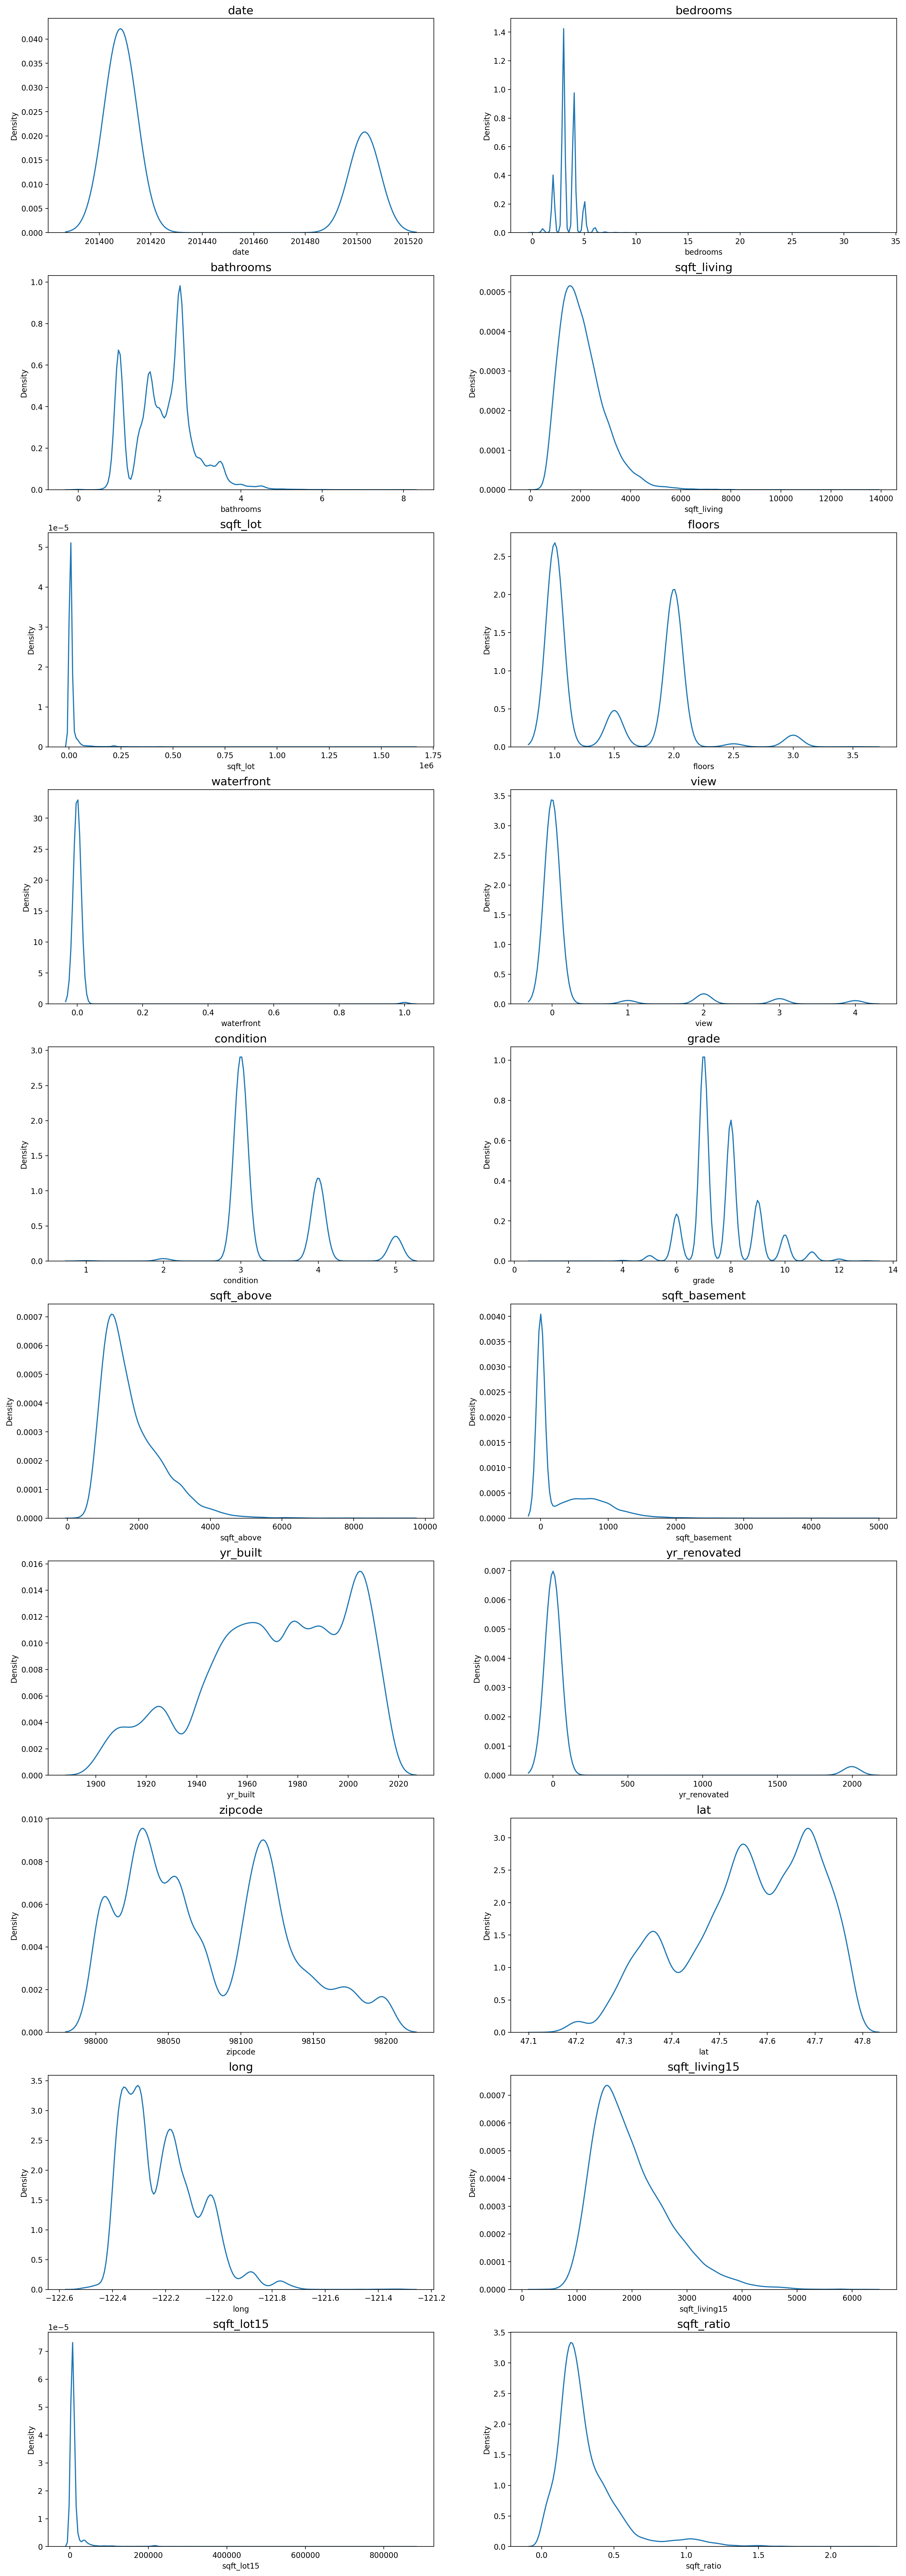

In [18]:
fig,ax = plt.subplots(10,2, figsize = (20,60))

count = 0
columns = train.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax = ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
    if count == 19:
        break

# Checking Skewness by columns

In [19]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 
                'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    
# Regularization

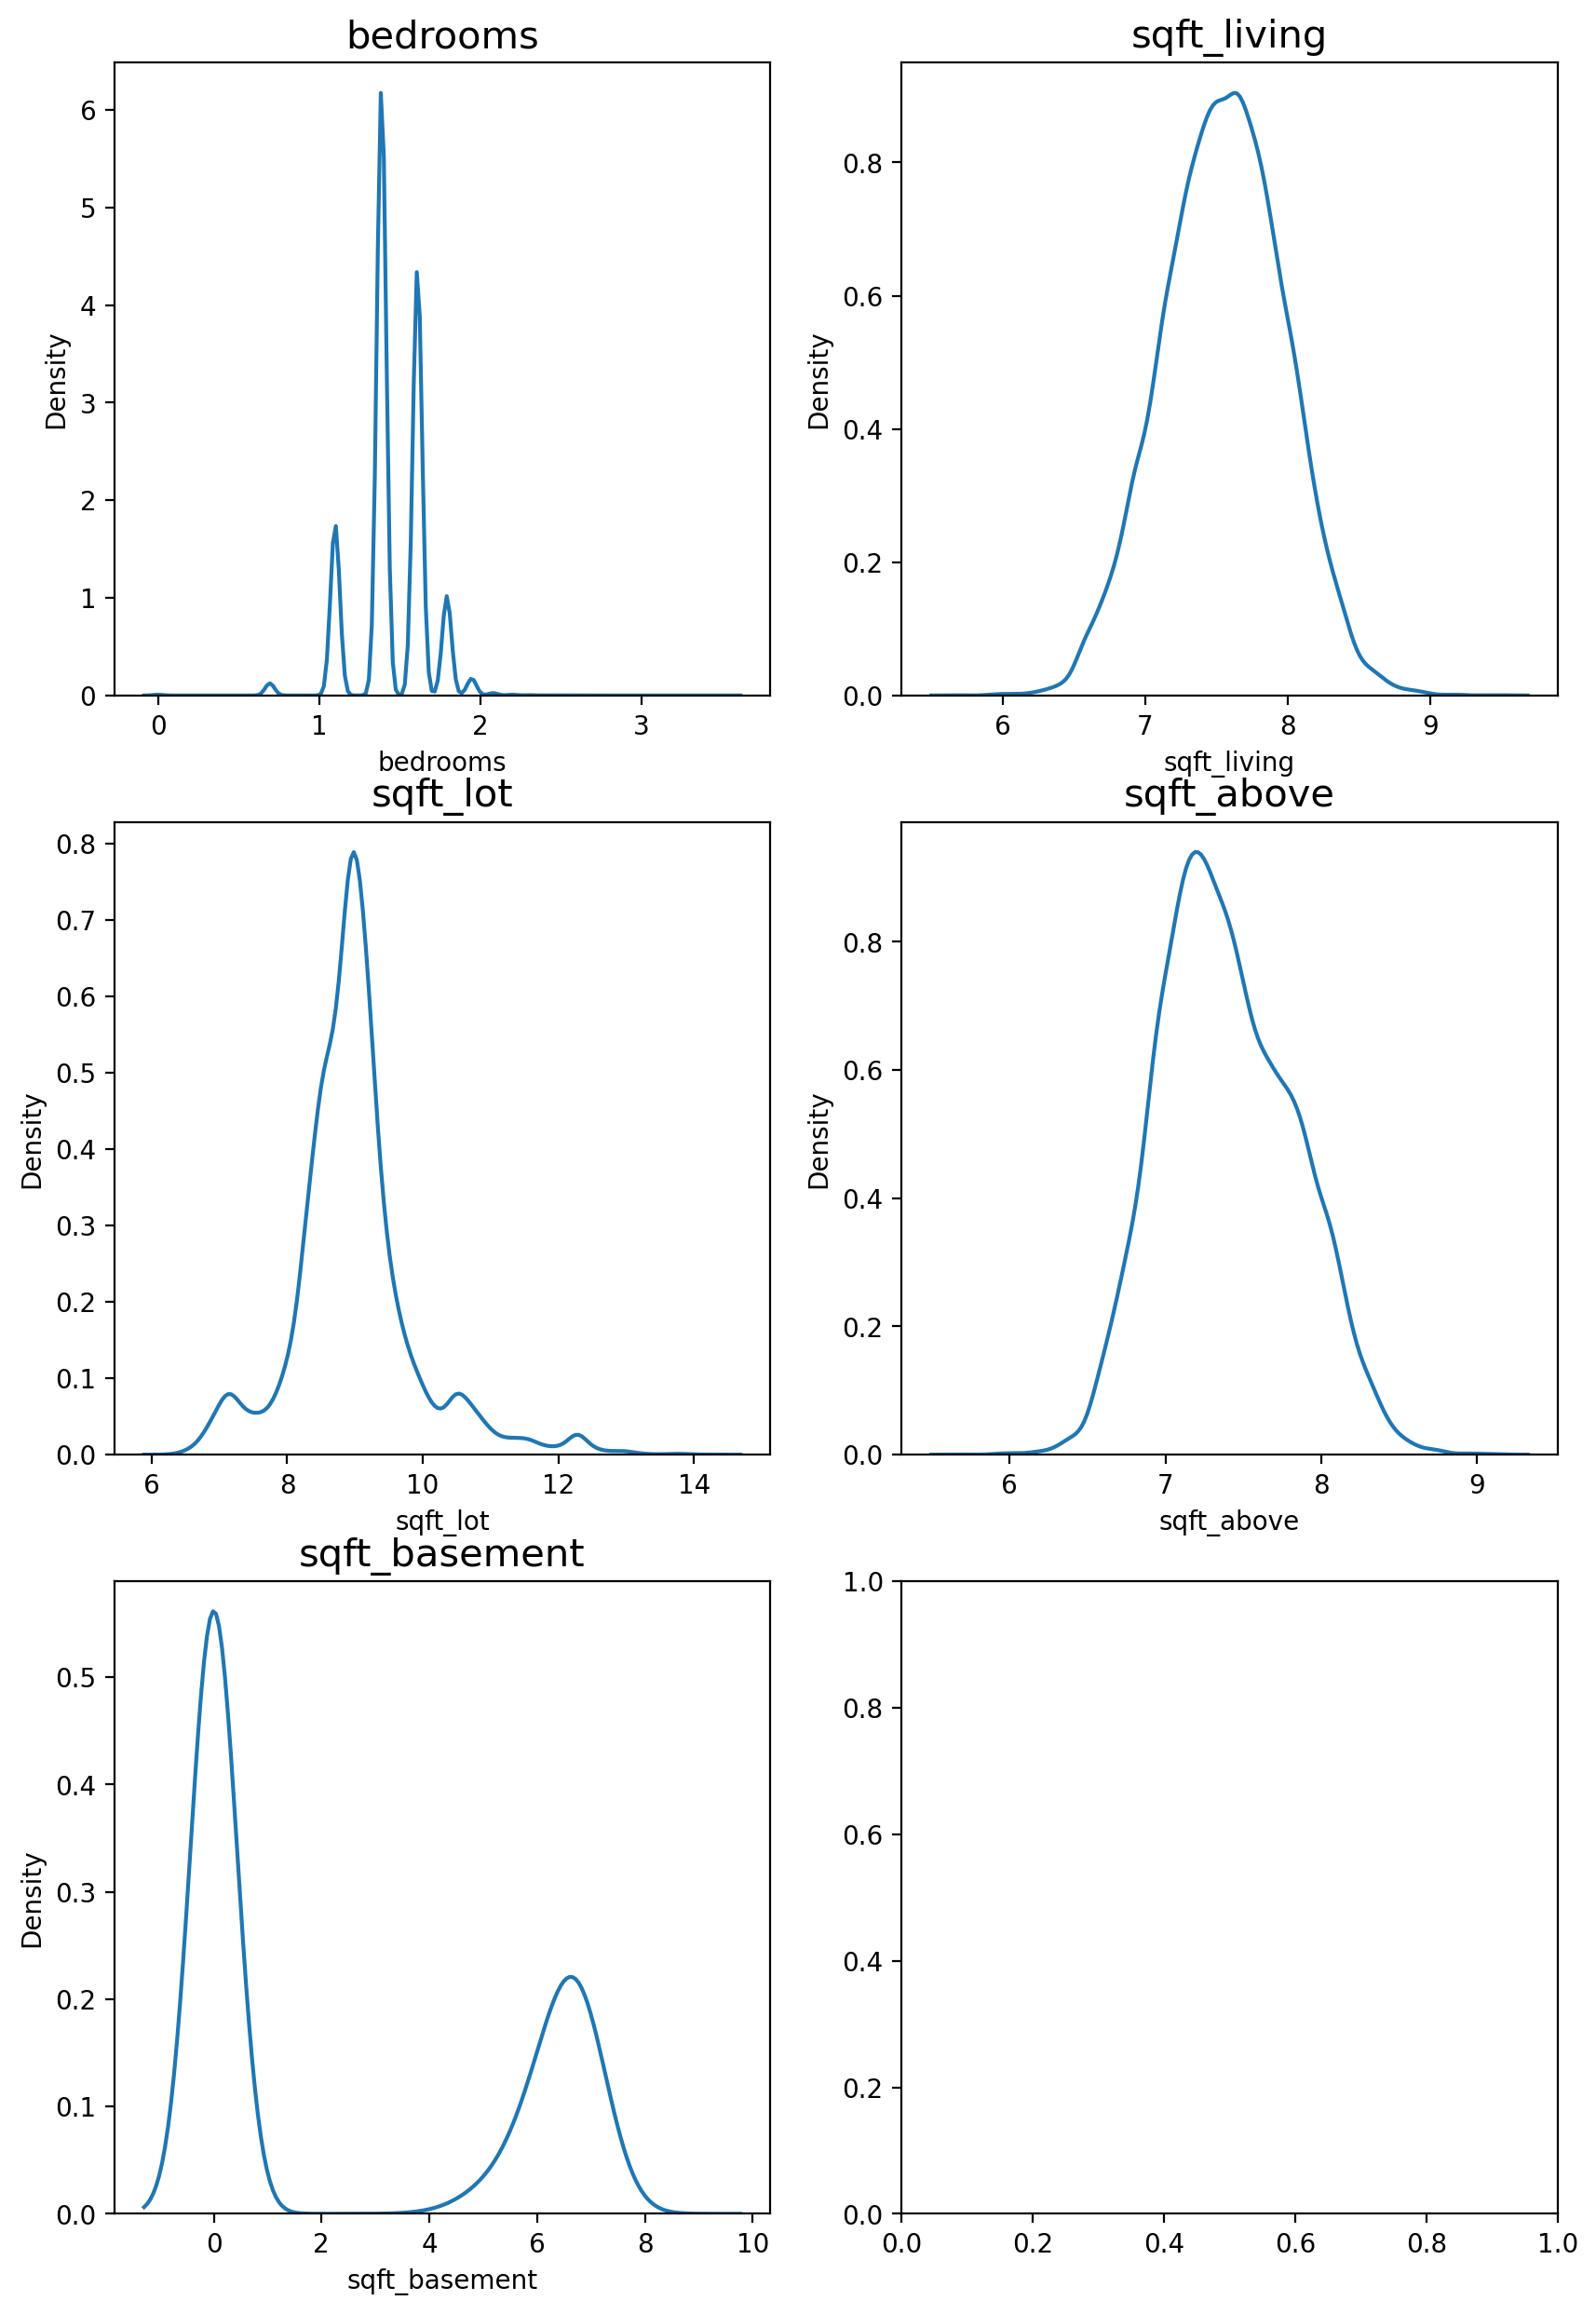

In [17]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

In [20]:
test = train.iloc[train_len:,:]
train = train.iloc[:train_len,:]

# Modeling

In [21]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(learning_rate = 0.05, random_state=2019)
lightgbm = lgb.LGBMRegressor(learning_rate = 0.05, random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]



In [22]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train.values, y, cv=kfold)))) 
                                             

In [23]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8604
Model XGBoost CV score : 0.8805
Model LightGBM CV score : 0.8772


In [24]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(train.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(test.values) for m in models
    ])
    return np.mean(predictions, axis=1)


In [26]:
y_pred = AveragingBlending(models, train, y, test)

In [27]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [31]:
sub.to_csv('~/Desktop/AIFFEL/submission.csv', index=False)